In [1]:
import os
import glob
import random
import numpy as np
import torch
import pandas as pd
import learn2learn as l2l
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
import warnings
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", message="The .grad attribute of a Tensor that is not a leaf Tensor is being accessed.*")

In [2]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda')

In [3]:
def load_data(path):
    mat = sio.loadmat(path)
    current_orig, ah_orig, time, ah = mat['current_orig'], mat['ah_orig'], mat['time'], mat['ah']
    current_orig_1 = torch.from_numpy(np.float32(-dimensional_y(current_orig, time_step, 1).reshape(-1)))
    ah_orig_1 = torch.from_numpy(np.float32(-dimensional_y(ah_orig, time_step, 1).reshape(-1)))
    ah_1 = torch.from_numpy(np.float32(dimensional_y(ah, time_step, 1).reshape(-1)))
    time_1 = torch.from_numpy(np.float32(dimensional_y(time, time_step, 1).reshape(-1)))
    data = {
        'current_orig': current_orig_1,
        'ah_orig': ah_orig_1,
        'ah': ah_1,
        'time': time_1
    }
    return data

In [4]:
def physical_inconsistency_batch(Q, I, t, output, output_bef,state='train'):
    if state == 'train':
        ah_dif = output_bef[1:]  - output[1:]
        ah_dif_2 = (I[:-1] / Q[1:]) * ((t[1:]-t[:-1]) / 3600)
        delt = torch.abs(ah_dif_2.reshape(-1,1) - ah_dif)
        pyh_loss = torch.sum(delt) / (len(output)-1)
    else:
        ah_dif = output_bef[1:]  - output[1:]
        ah_dif_2 = (I[1:] / Q[1:]) * ((t[1:]-t[:-1]) / 3600)
        delt = torch.abs(ah_dif_2.reshape(-1,1) - ah_dif)
        pyh_loss = torch.sum(delt) / (len(output)-1)
    return pyh_loss

In [5]:
def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device, tag, data_orig,capacity_rated):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    current_orig_1 = data_orig['current_orig'].to(device)
    ah_orig_1 = data_orig['ah_orig'].to(device)
    time_1 = data_orig['time'].to(device)
    adaptation_data, adaptation_labels = data, labels
    with torch.backends.cudnn.flags(enabled=False):
        if tag == 'train':
            for step in range(adaptation_steps):
                output, out_bef, coefficient = learner(adaptation_data)
                PHY_loss = physical_inconsistency_batch(capacity_rated * coefficient, current_orig_1, time_1, output, out_bef)#
                output[1:] =  (output[1:] + out_bef[1:]+(((current_orig_1[:-1]/(coefficient[1:]*capacity_rated))*((time_1[1:]-time_1[:-1]) / 3600))).reshape(-1,1))/2
                empirical_error = loss(output, adaptation_labels)
                train_error = empirical_error+ PHY_loss
                learner.adapt(train_error)
        predictions, predictions_bef, coefficient= learner(adaptation_data)
        PHY_loss = physical_inconsistency_batch(capacity_rated * coefficient, current_orig_1, time_1, predictions, predictions_bef)
        predictions[1:] =  (predictions[1:] + predictions_bef[1:]+(((current_orig_1[1:]/(coefficient[1:]*capacity_rated))*((time_1[1:]-time_1[:-1]) / 3600))).reshape(-1,1))/2
        empirical_error = loss(predictions, adaptation_labels)
        valid_error = empirical_error+ PHY_loss
        _, _, valid_rmse = evaluation(predictions.cpu().detach().numpy(), adaptation_labels.cpu().detach().numpy())
        del predictions, predictions_bef, current_orig_1, ah_orig_1, time_1, adaptation_data, adaptation_labels,capacity_rated
        return valid_error, valid_rmse

In [6]:
def dimensional_x (x,time_step,step):
    l = []
    x = x[::step]
    batch_size = x.shape[0]-time_step + 1  #full batch
    x_1 = x
    for i in range(batch_size):
        x = x_1[i:i+time_step]
        l.append(x)
    x = np.array(l)
    x = x.astype(float)
    return x

def dimensional_y (y,time_step,step):
    y = y[::step]
    y = y[time_step-1:]
    return y
class Mydataset(Dataset):
  def __init__(self, data_path,temp, set, mode='train'):
    self.X, self.Y = [], []
    total = 0
    for name in set:
      path = data_path  + temp +'/'+ name +'.mat'
      mat = sio.loadmat(path)
      current,voltage,battery_temp,ah,soc = mat['current'],mat['voltage'],mat['temp'],mat['ah'],mat['soc']
      data = np.c_[current,voltage,battery_temp,ah]
      self.X.append(data)
      self.Y.append(soc)
    if mode == 'train':
      print('get data')
      for i in range(len(set)):
        self.X[i] = dimensional_x(self.X[i],time_step,1)
        self.Y[i] = dimensional_y(self.Y[i],time_step,1)
        self.X[i] = torch.from_numpy(self.X[i])
        self.Y[i] = torch.from_numpy(self.Y[i])
        self.X[i] = self.X[i].type(torch.FloatTensor)
        self.Y[i] = self.Y[i].type(torch.FloatTensor)
    elif mode == 'test':
      for i in range(len(set)):
        print('shape:{},{}'.format(self.X[i].shape,self.Y[i].shape))
        self.X[i] = dimensional_x(self.X[i],time_step,1)
        self.Y[i] = dimensional_y(self.Y[i],time_step,1)
        self.X[i] = torch.from_numpy(self.X[i])
        self.Y[i] = torch.from_numpy(self.Y[i])
        self.X[i] = self.X[i].type(torch.FloatTensor)
        self.Y[i] = self.Y[i].type(torch.FloatTensor)
  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]
  
  def __len__(self):
    return len(self.X)

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, n_class=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) 
        self.linear2 = nn.Linear(hidden_dim, n_class)  
        self.pool = nn.MaxPool1d(kernel_size=time_step)  
        self.fc = nn.Linear(in_features=128, out_features=1)  
    def forward(self, x):  
        out, _ = self.cell(x) 
        out1 = self.linear1(out)
        out1 = F.relu(out1)
        out1 = self.linear2(out1)
        out1_bef=out1[:, -2, :]
        out1=out1[:, -1, :]
        x = out.permute(0, 2, 1)  
        x = self.pool(x)  
        x = x.view(x.size(0), -1)  
        x = torch.sigmoid(self.fc(x)).reshape(-1)  
        return out1,out1_bef,x  

In [8]:
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae,mse,rmse

In [9]:
ways=1
shots=1
meta_lr=0.005
fast_lr=0.25
meta_batch_size=48
adaptation_steps=1
num_iterations=100
cuda=True
time_step = 8
feature_num = 3

In [10]:
data_path= './'
folder_path = r'D:\data\jupyter_data\soc\fivefold\modif_gather'
folder_names = os.listdir(folder_path)

In [11]:
save_folder = 'D:/data/jupyter_data/soc/fivefold/modif_gather/data_excel/'

get data
get data


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0026 |MSE:0.0000 | RMSE:0.0038| type:Cycle1_0_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0023 |MSE:0.0000 | RMSE:0.0037| type:Cycle3_N10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0021 |MSE:0.0000 | RMSE:0.0030| type:Cycle4_10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0017 |MSE:0.0000 | RMSE:0.0022| type:DST_25_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0030 |MSE:0.0000 | RMSE:0.0043| type:HWFET_0_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0089 |MSE:0.0001 | RMSE:0.0101| type:ND_1_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0097 |MSE:0.0001 | RMSE:0.0110| type:ND_2_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0082 |MSE:0.0001 | RMSE:0.0093| type:ND_3_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0029 |MSE:0.0000 | RMSE:0.0039| type:UDDS_10_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0059 |MSE:0.0000 | RMSE:0.0064| type:US06_0_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0053 |MSE:0.0001 | RMSE:0.0081| type:US06_N10_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0067 |MSE:0.0001 | RMSE:0.0095| type:US06_N10_Pan
get data
get data
MAE:0.0030 |MSE:0.0000 | RMSE:0.0038| type:Cycle1_N10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0024 |MSE:0.0000 | RMSE:0.0030| type:Cycle2_10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0017 |MSE:0.0000 | RMSE:0.0019| type:DST_0_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0151 |MSE:0.0003 | RMSE:0.0167| type:FUDS_N10_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0085 |MSE:0.0001 | RMSE:0.0101| type:HC_1_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0095 |MSE:0.0001 | RMSE:0.0114| type:HC_2_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0094 |MSE:0.0001 | RMSE:0.0113| type:HC_3_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0033 |MSE:0.0000 | RMSE:0.0040| type:LA92_10_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
C:\Users\Admin\AppData\Local\Temp\ipykernel_23632\4247648644.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(9,7))#定义图像大小


MAE:0.0025 |MSE:0.0000 | RMSE:0.0032| type:UDDS_10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0034 |MSE:0.0000 | RMSE:0.0040| type:UDDS_N10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0060 |MSE:0.0001 | RMSE:0.0072| type:US06_10_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0022 |MSE:0.0000 | RMSE:0.0027| type:US06_10_Pan
get data
get data
MAE:0.0017 |MSE:0.0000 | RMSE:0.0020| type:Cycle3_10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0029 |MSE:0.0000 | RMSE:0.0036| type:Cycle4_0_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0063 |MSE:0.0001 | RMSE:0.0073| type:DST_10_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0180 |MSE:0.0004 | RMSE:0.0202| type:DST_N10_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0113 |MSE:0.0002 | RMSE:0.0131| type:FUDS_10_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0019 |MSE:0.0000 | RMSE:0.0023| type:FUDS_25_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0026 |MSE:0.0000 | RMSE:0.0032| type:LA92_0_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0019 |MSE:0.0000 | RMSE:0.0022| type:LA92_10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0032 |MSE:0.0000 | RMSE:0.0047| type:US06_0_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0031 |MSE:0.0000 | RMSE:0.0040| type:US06_25_LG
get data
get data


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0009 |MSE:0.0000 | RMSE:0.0012| type:Cycle1_10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0027 |MSE:0.0000 | RMSE:0.0034| type:Cycle2_0_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0025 |MSE:0.0000 | RMSE:0.0036| type:Cycle4_N10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0033 |MSE:0.0000 | RMSE:0.0037| type:HWFET_0_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0033 |MSE:0.0000 | RMSE:0.0051| type:HWFET_10_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0023 |MSE:0.0000 | RMSE:0.0030| type:LA92_25_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0030 |MSE:0.0000 | RMSE:0.0038| type:LA92_N10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0012 |MSE:0.0000 | RMSE:0.0015| type:RP_1_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0015 |MSE:0.0000 | RMSE:0.0018| type:RP_2_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0025 |MSE:0.0000 | RMSE:0.0030| type:RP_3_45_Own


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0024 |MSE:0.0000 | RMSE:0.0030| type:UDDS_25_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0109 |MSE:0.0001 | RMSE:0.0113| type:US06_10_LG
get data
get data
MAE:0.0013 |MSE:0.0000 | RMSE:0.0016| type:Cycle2_N10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0033 |MSE:0.0000 | RMSE:0.0039| type:Cycle3_0_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0077 |MSE:0.0001 | RMSE:0.0088| type:FUDS_0_A123


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0025 |MSE:0.0000 | RMSE:0.0035| type:HWFET_10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0019 |MSE:0.0000 | RMSE:0.0026| type:HWFET_N10_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0013 |MSE:0.0000 | RMSE:0.0018| type:LA92_0_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0014 |MSE:0.0000 | RMSE:0.0021| type:UDDS_0_LG


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0032 |MSE:0.0000 | RMSE:0.0039| type:UDDS_0_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0045 |MSE:0.0000 | RMSE:0.0053| type:US06_0_Pan


C:\Users\Admin\.conda\envs\gym\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE:0.0012 |MSE:0.0000 | RMSE:0.0015| type:US06_25_A123


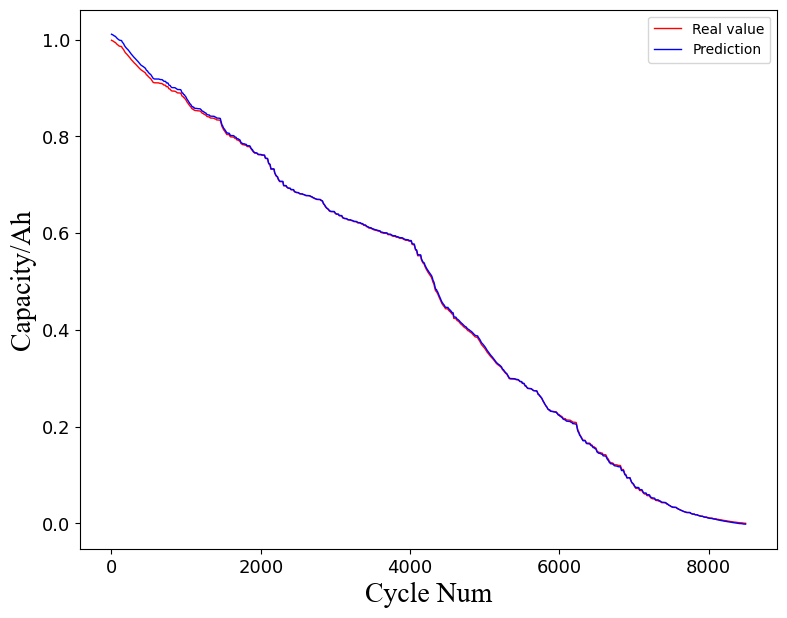

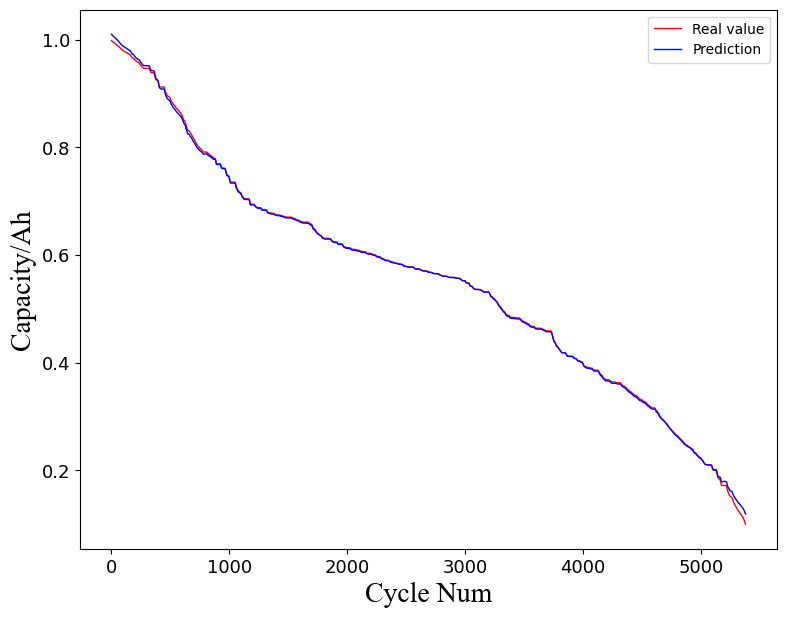

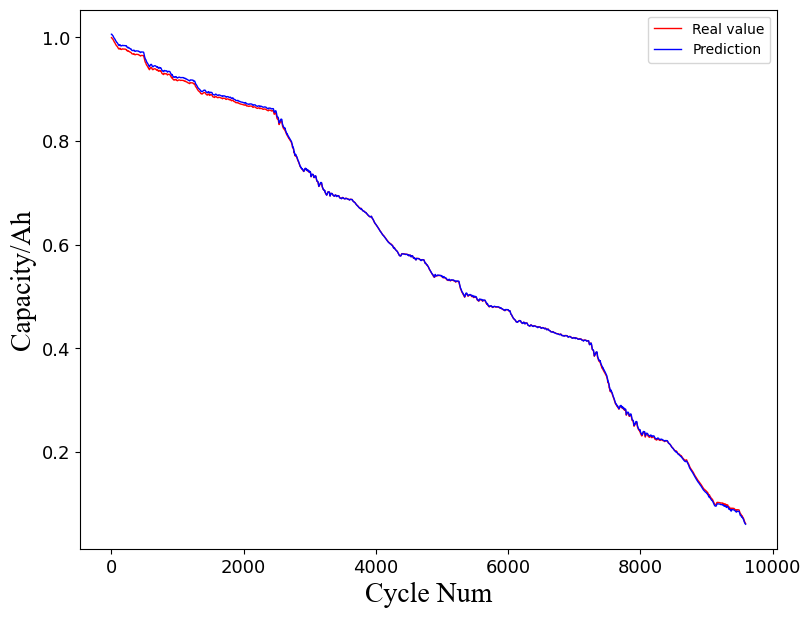

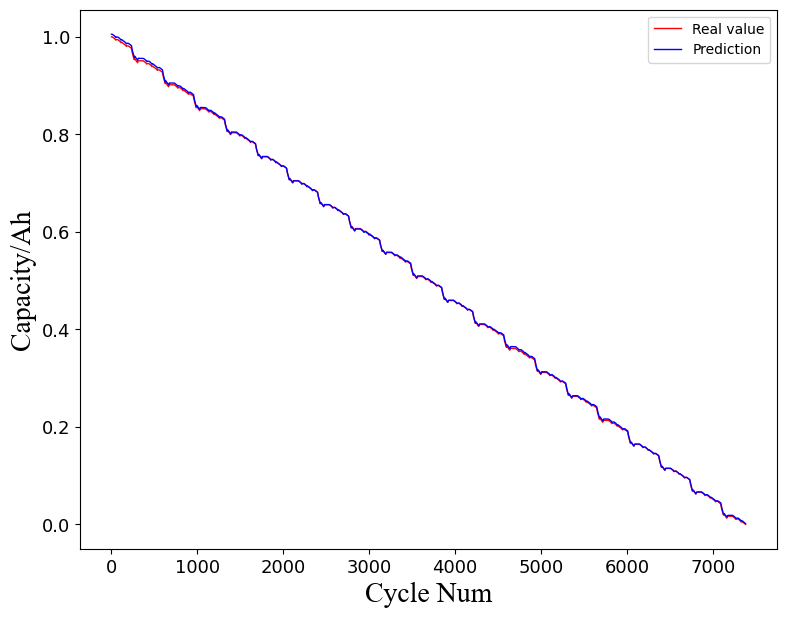

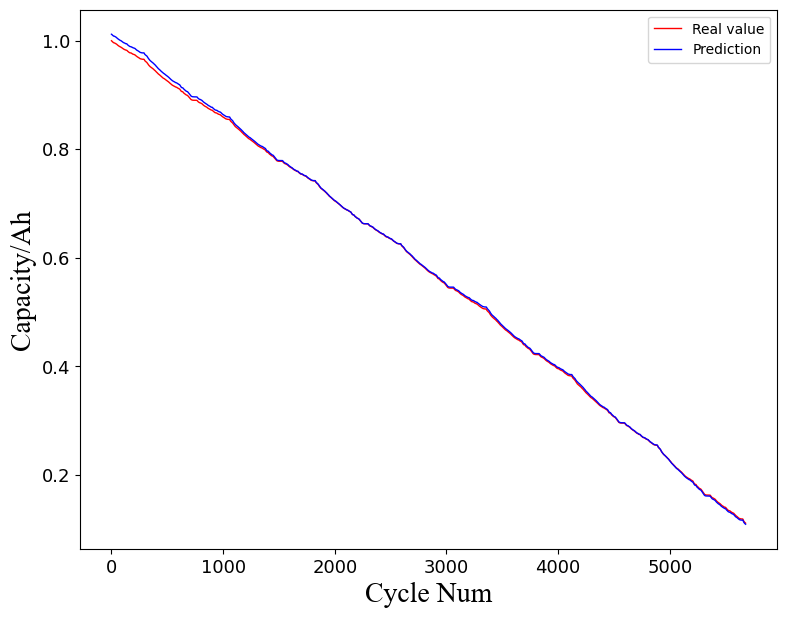

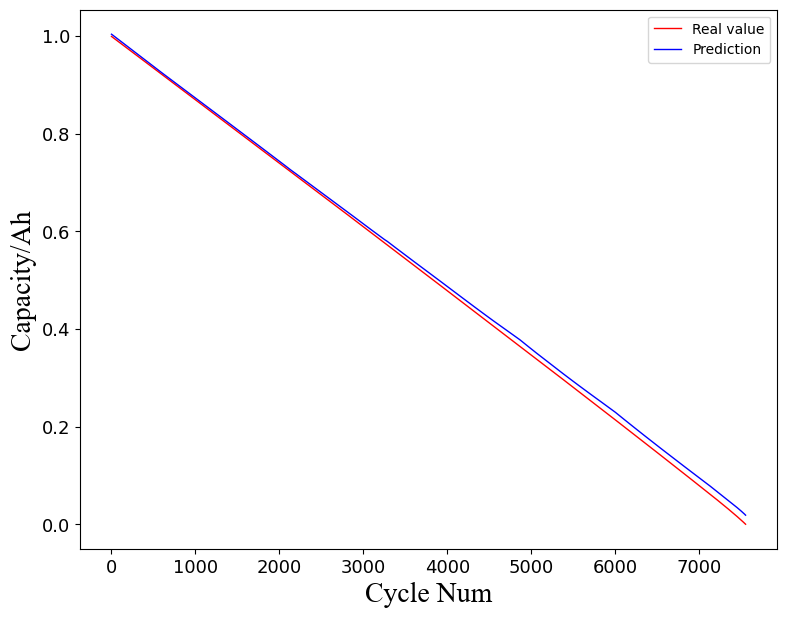

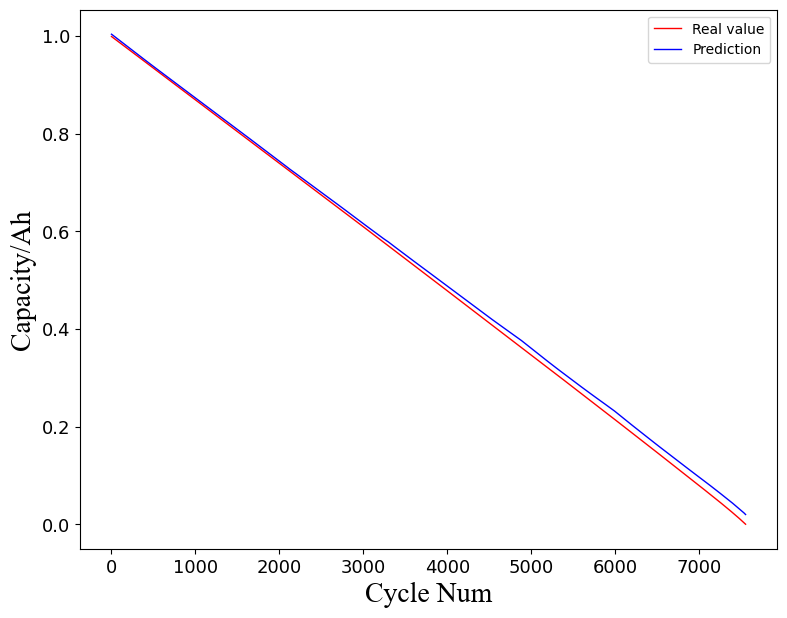

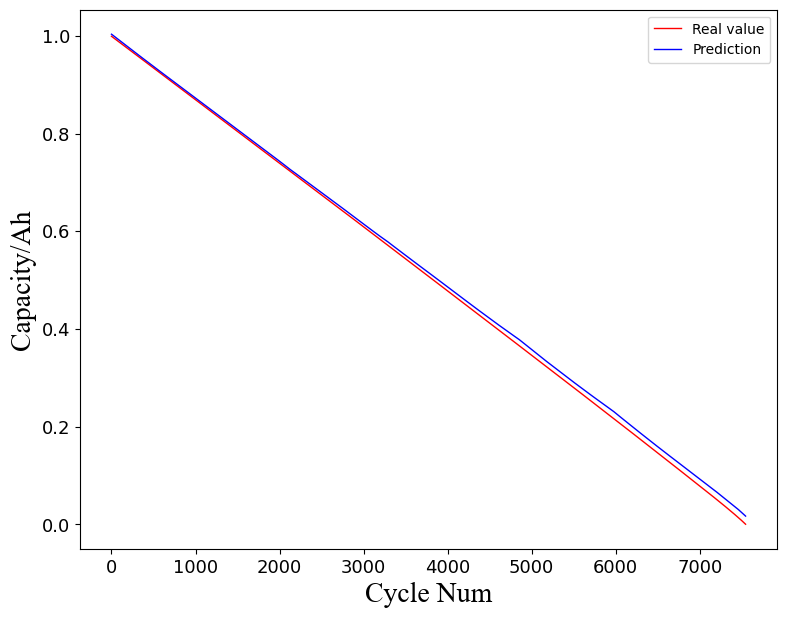

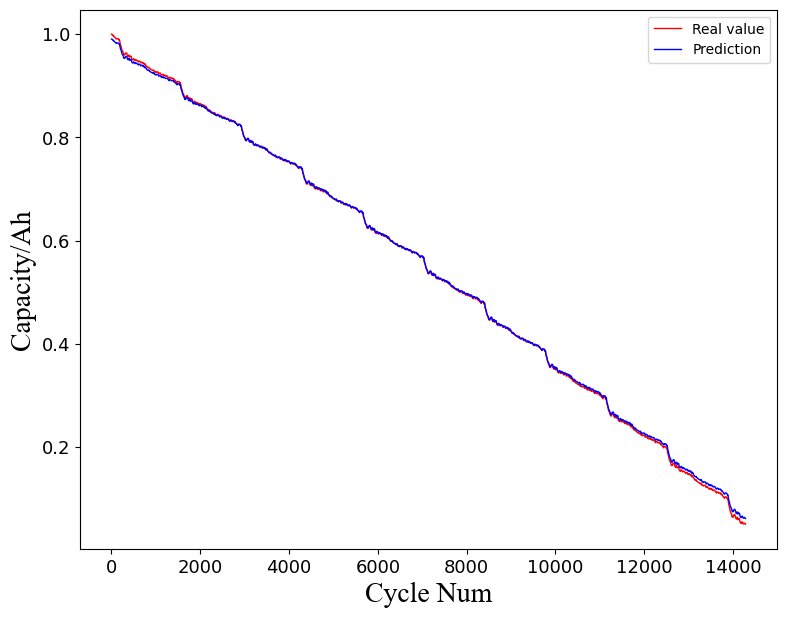

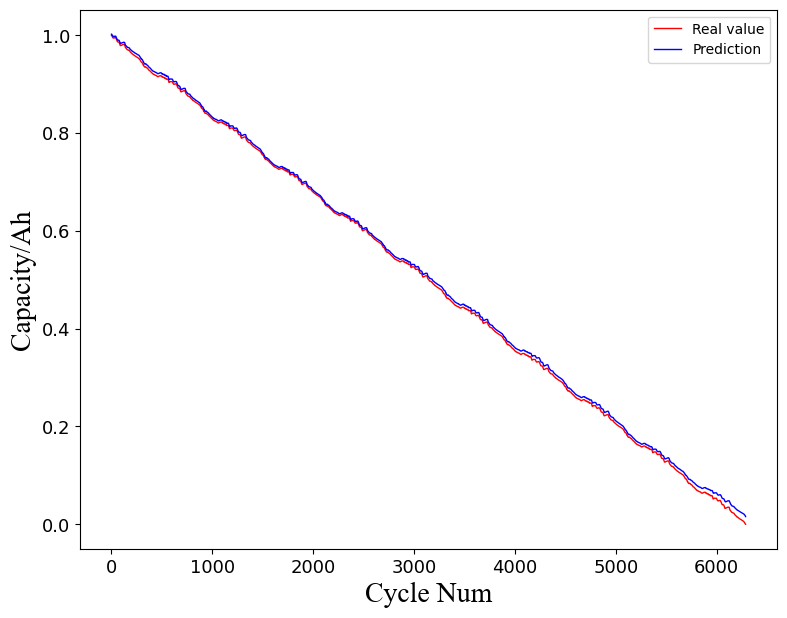

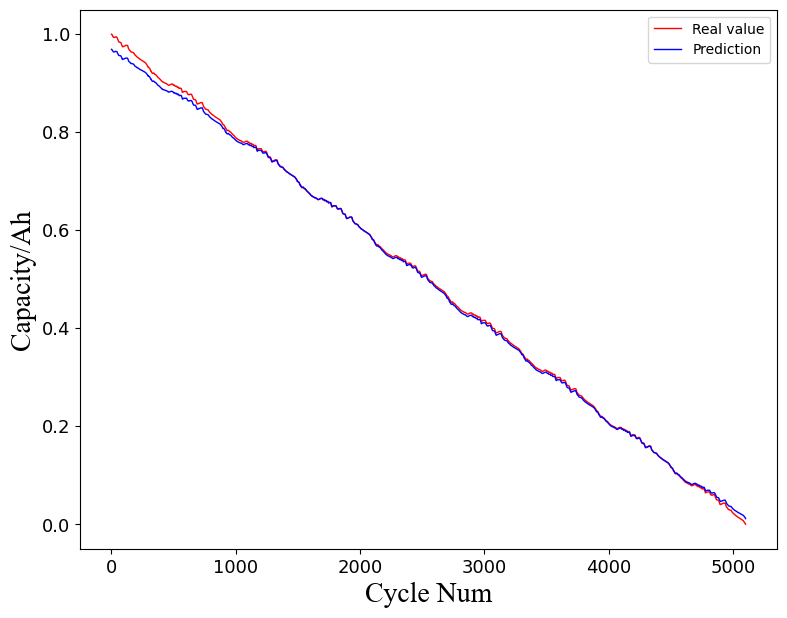

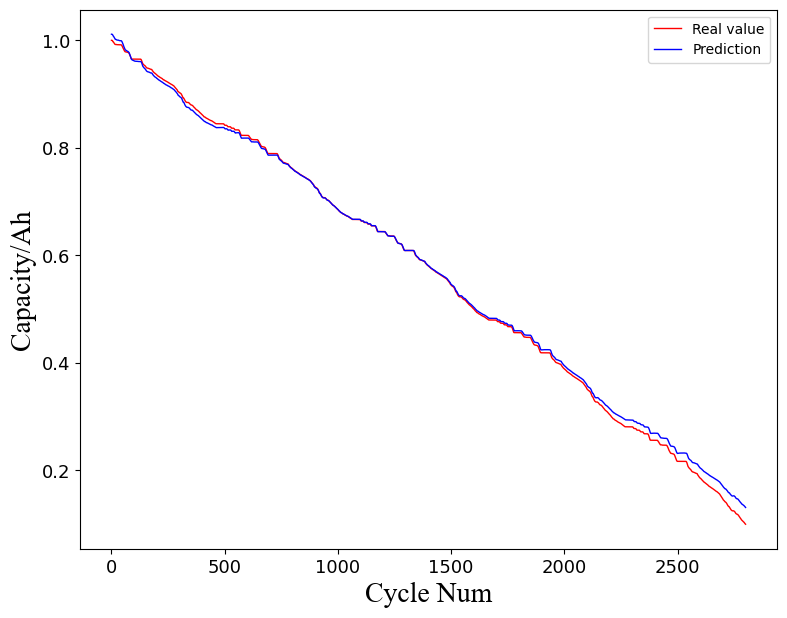

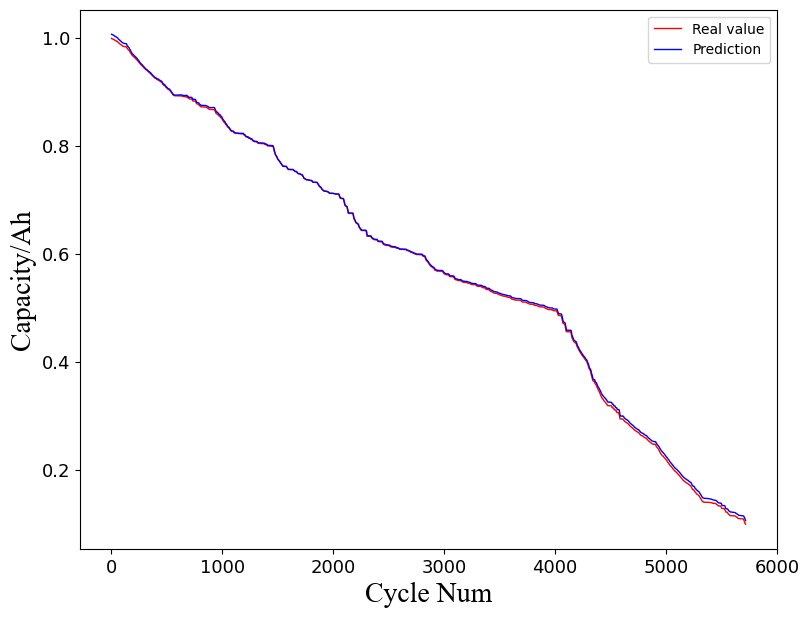

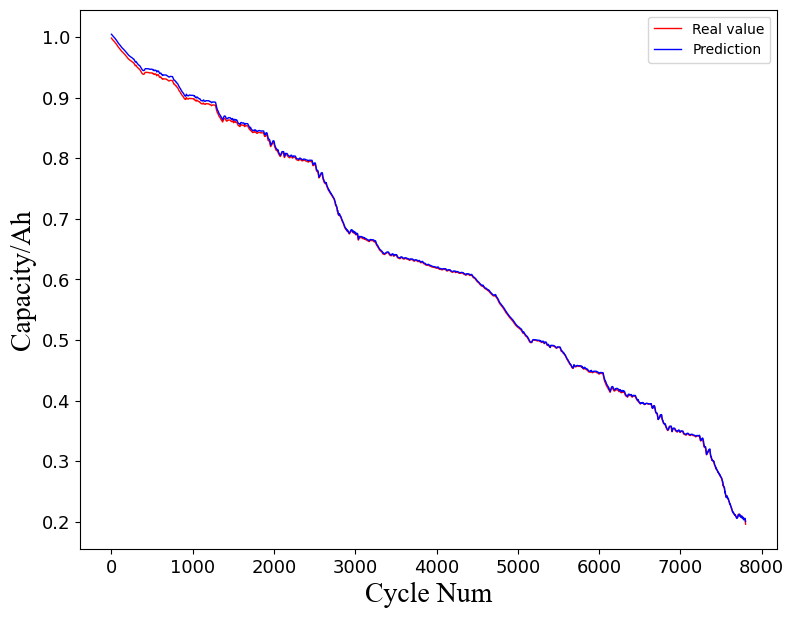

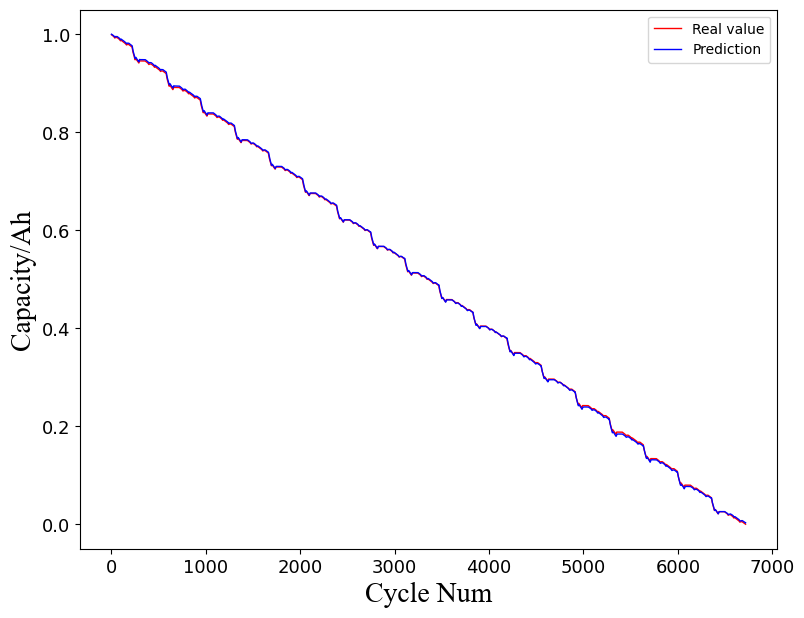

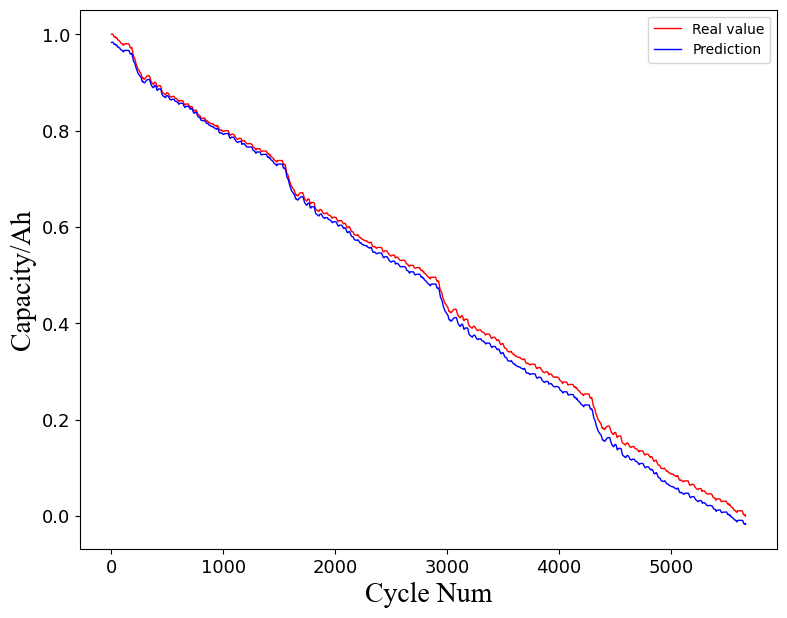

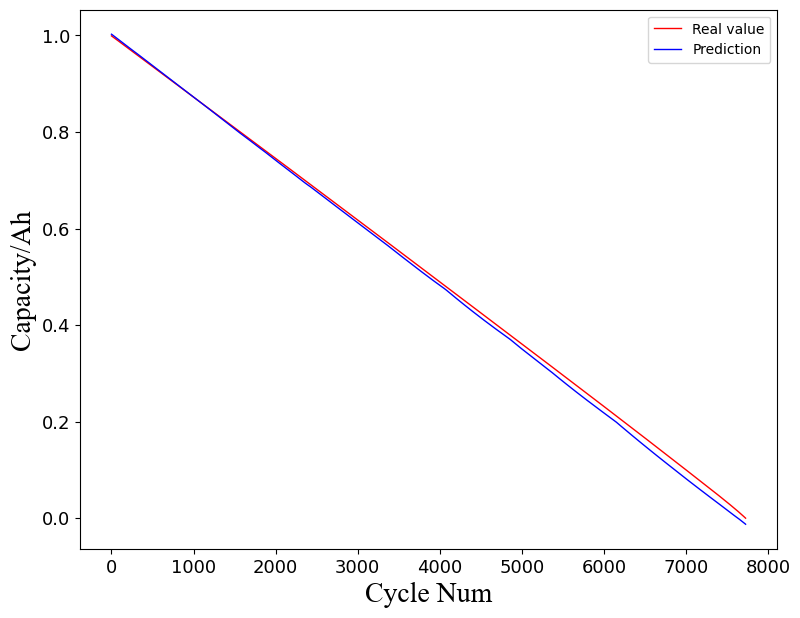

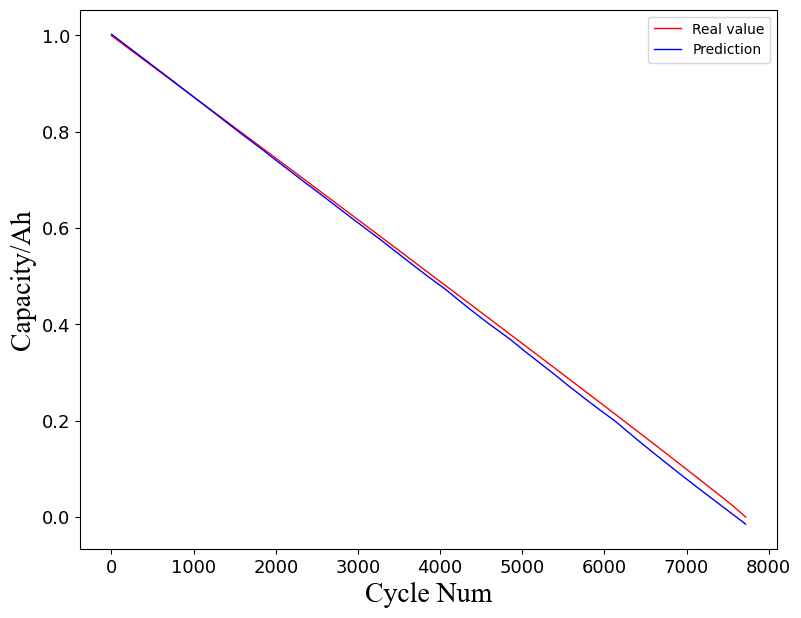

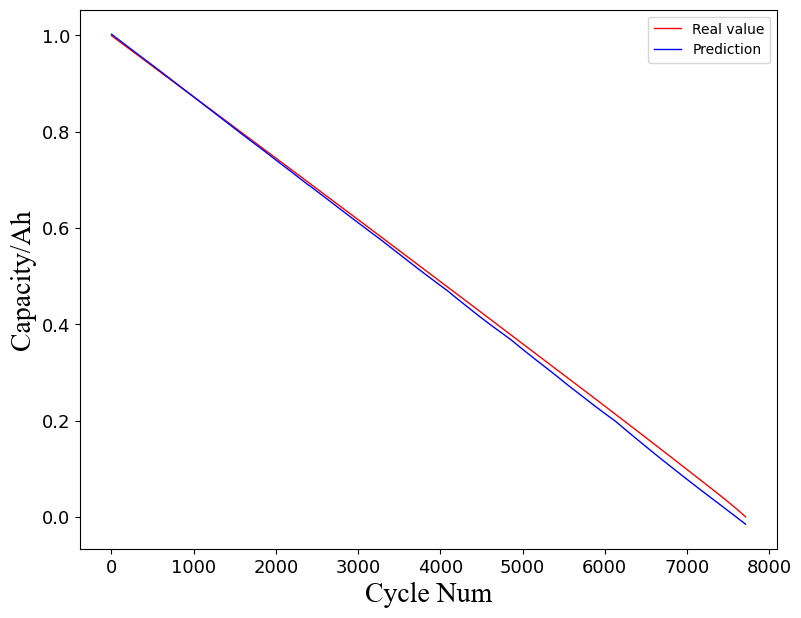

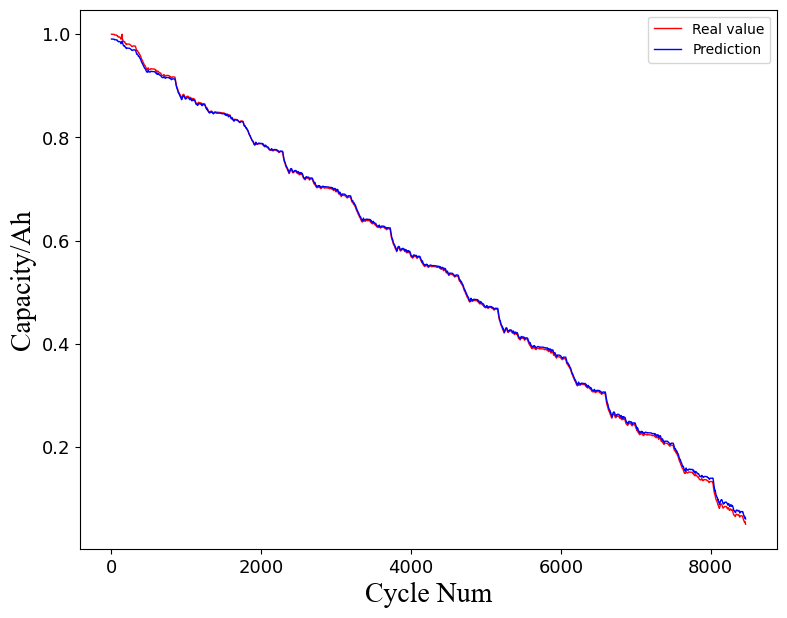

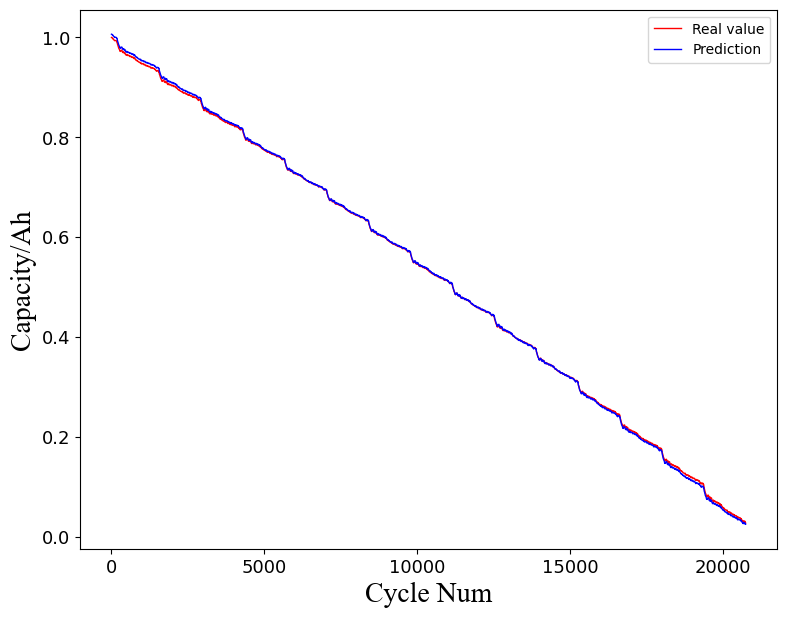

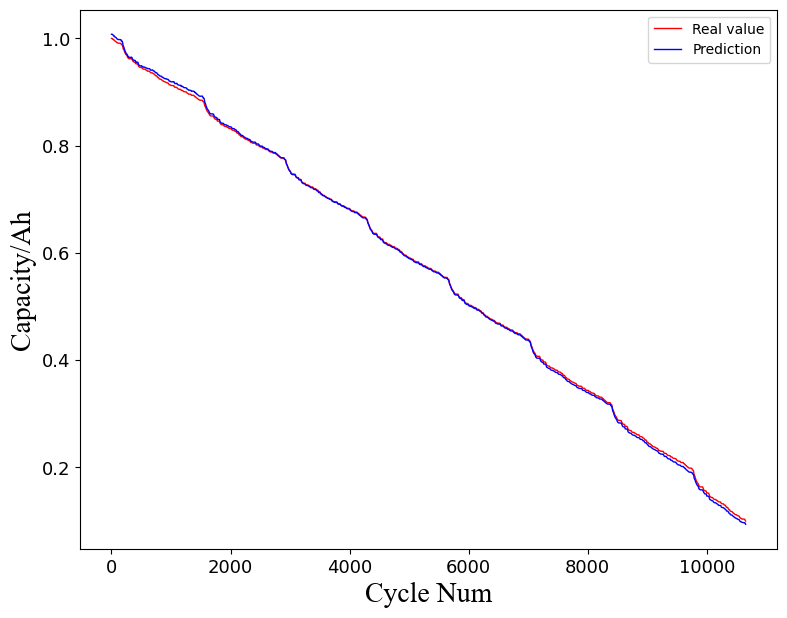

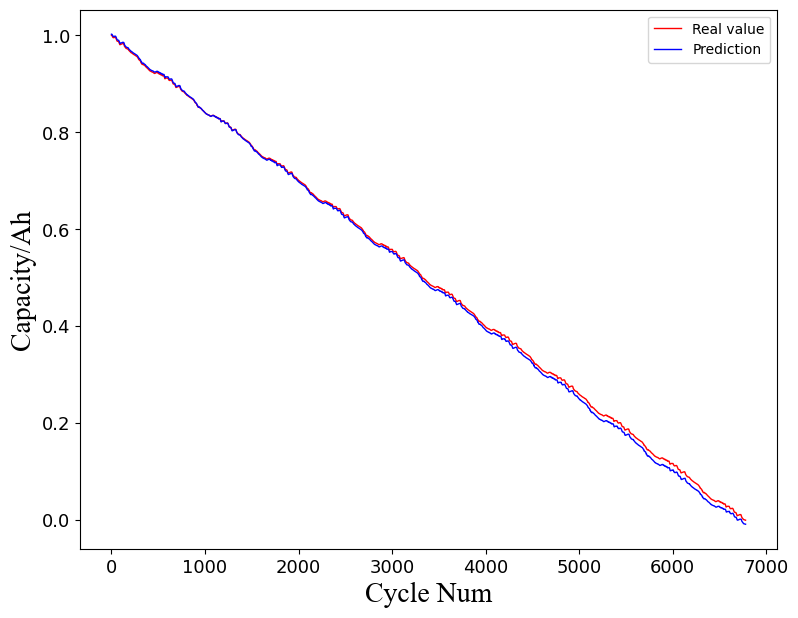

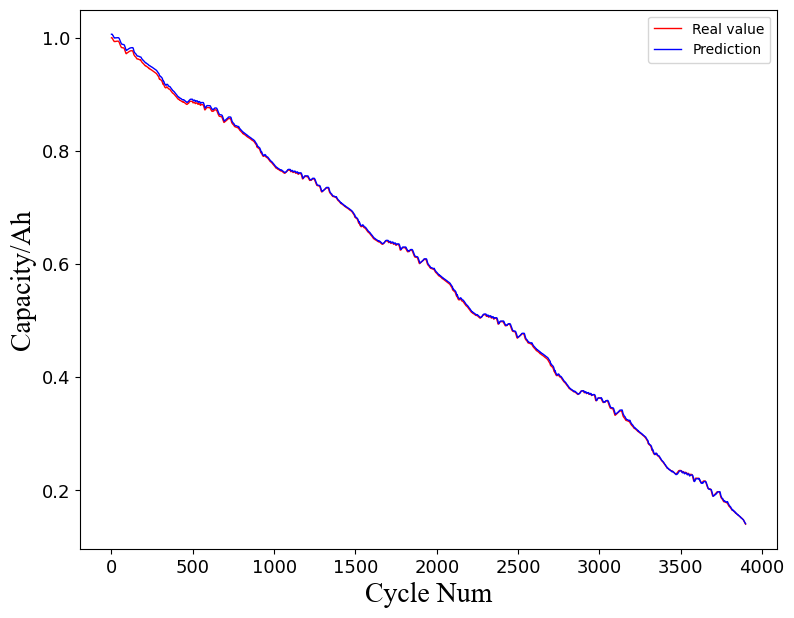

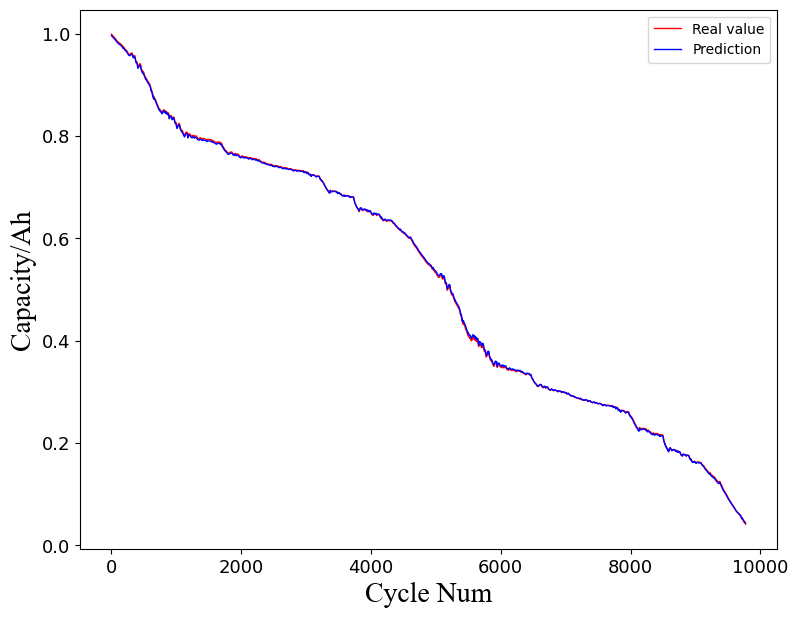

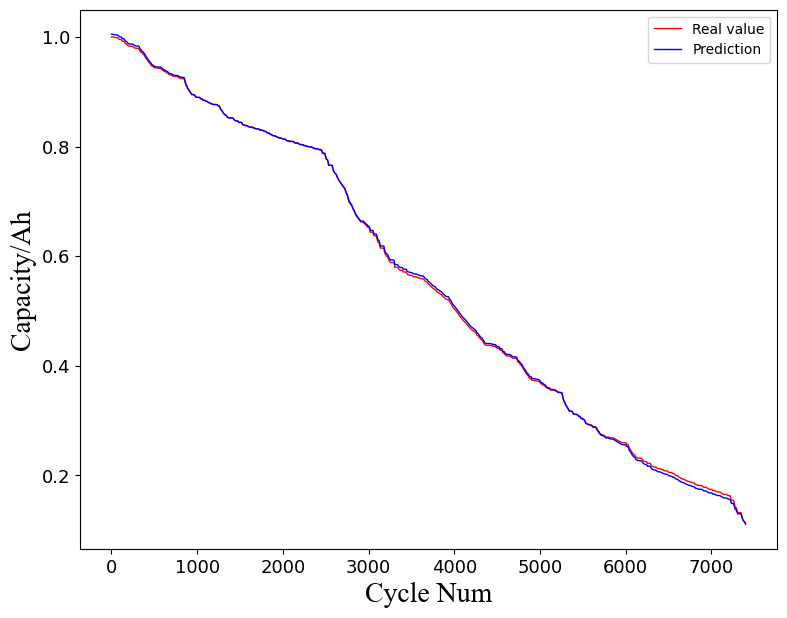

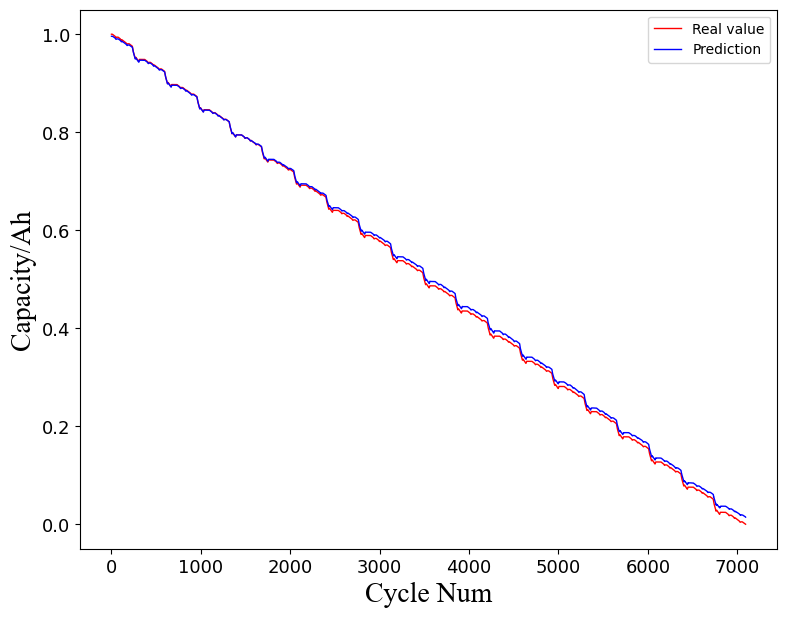

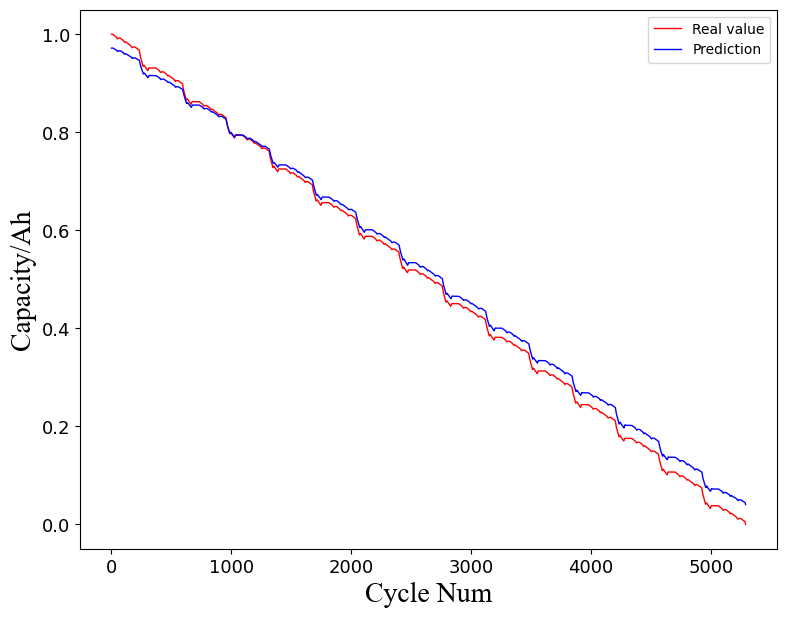

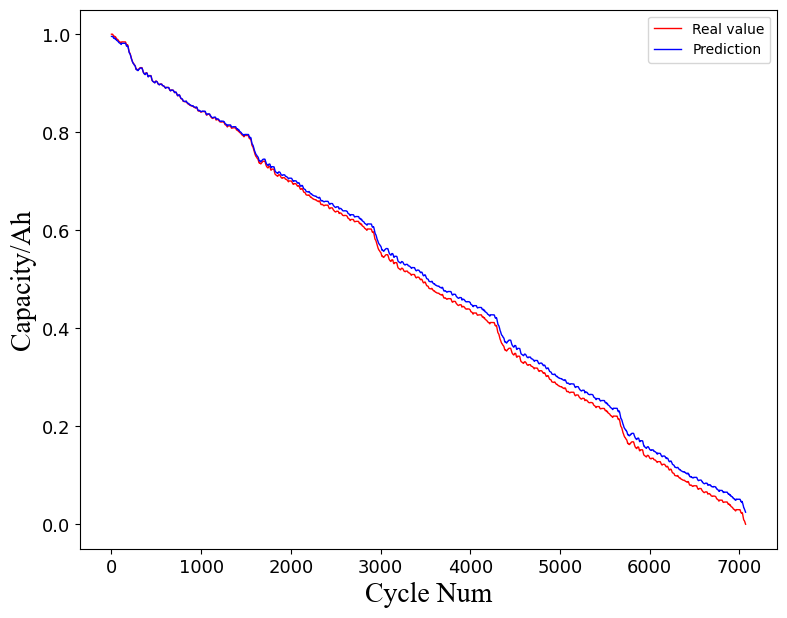

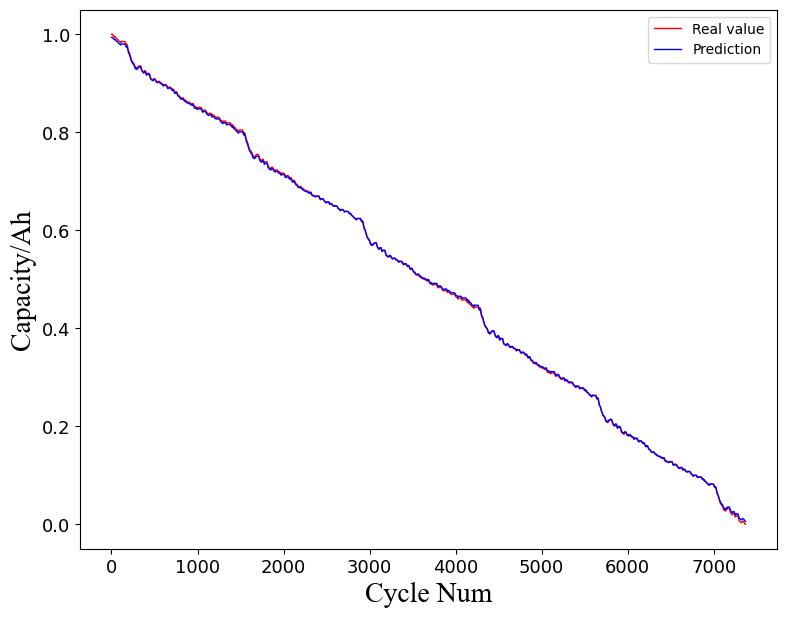

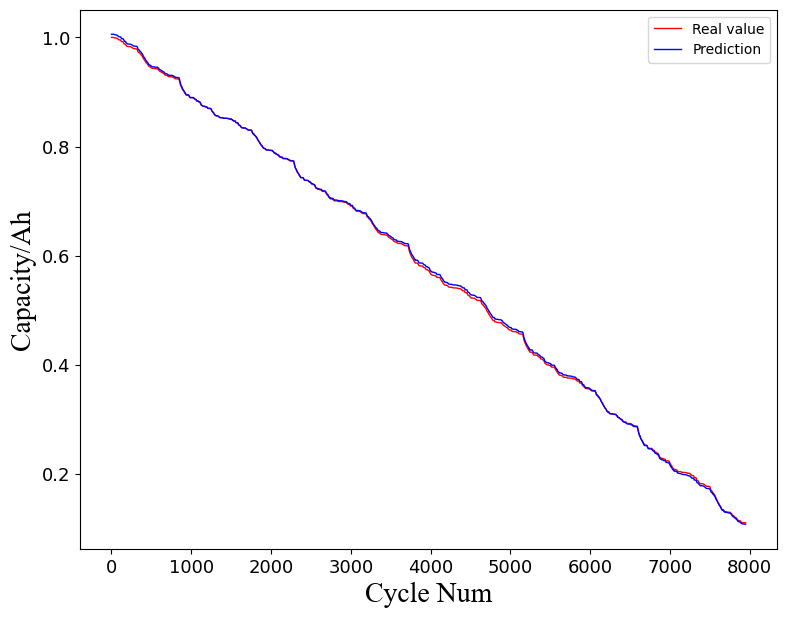

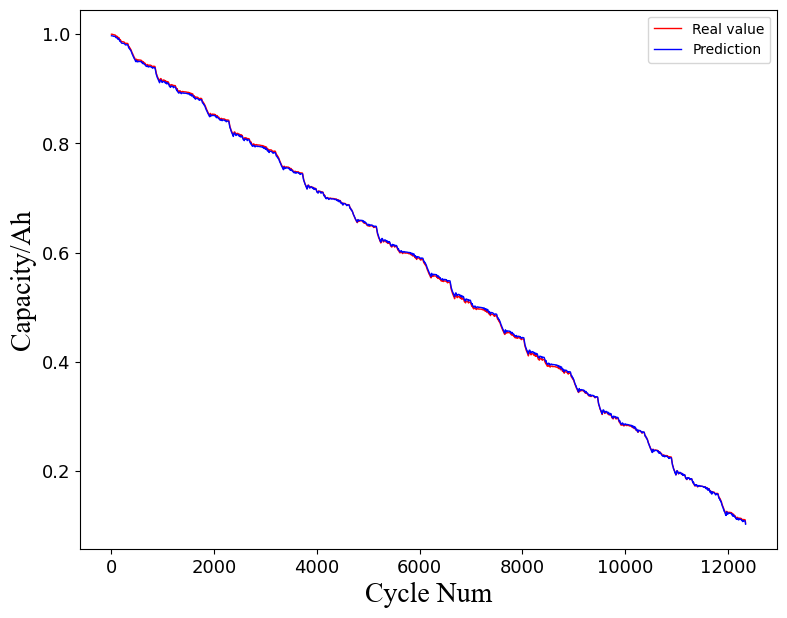

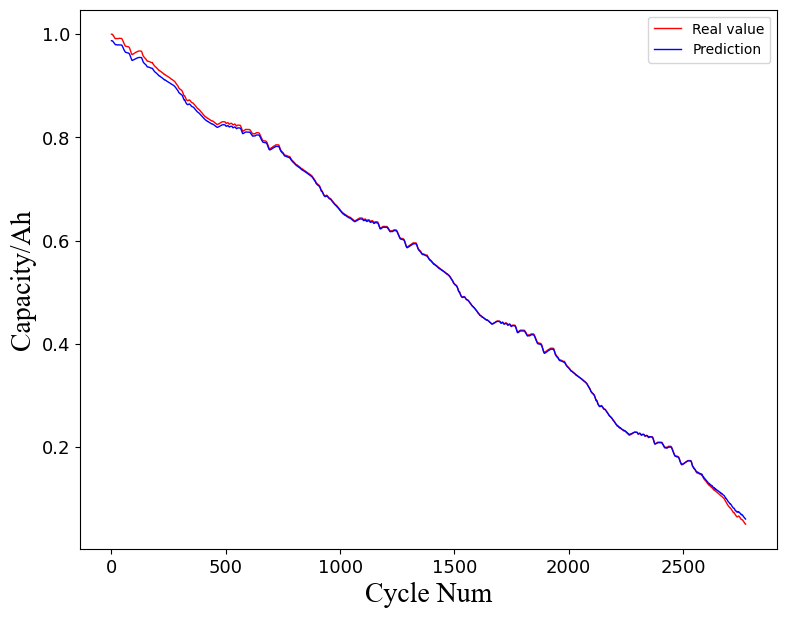

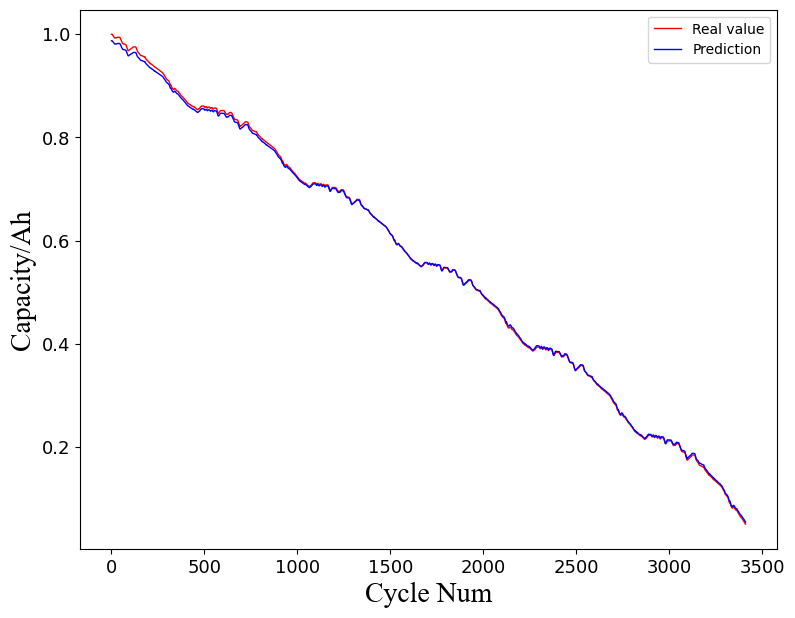

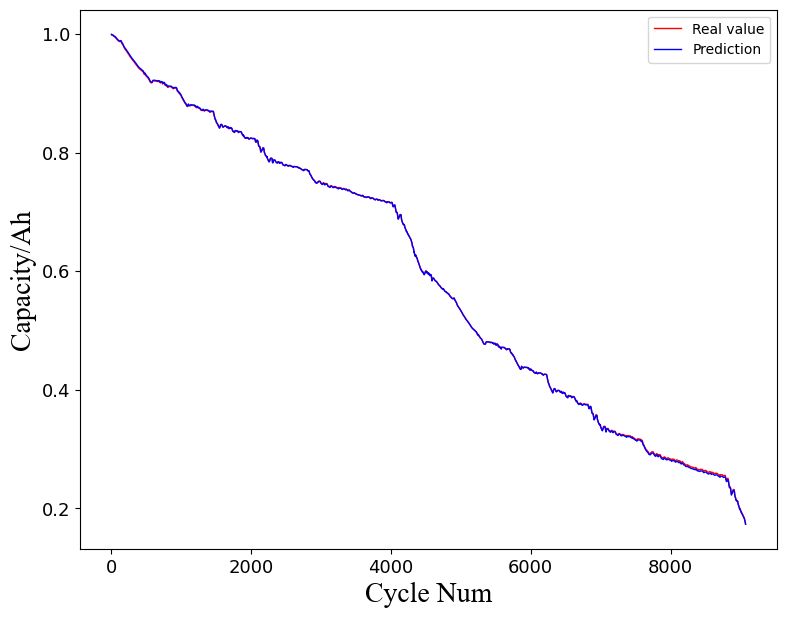

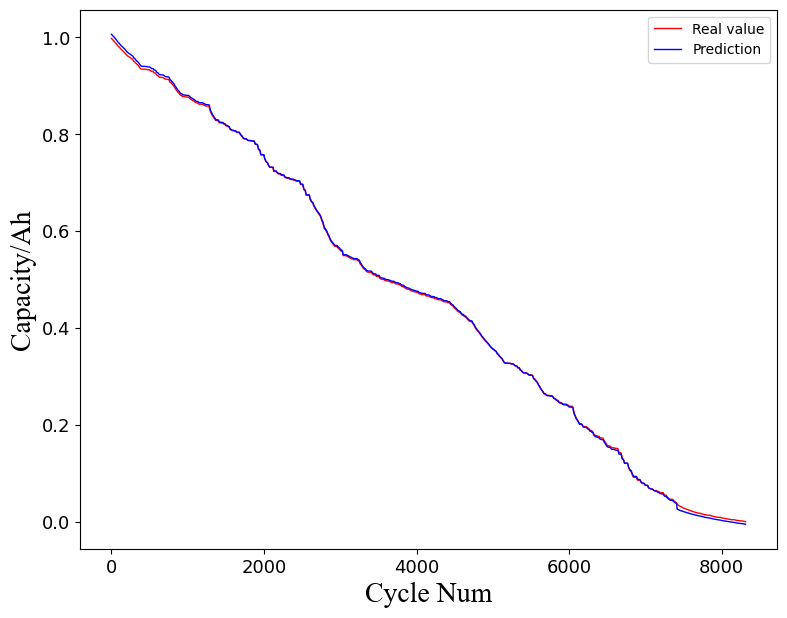

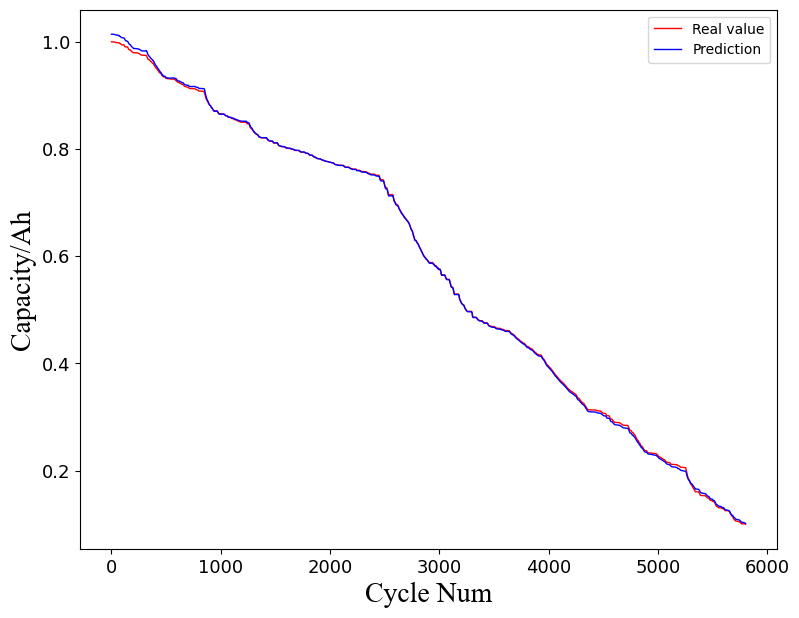

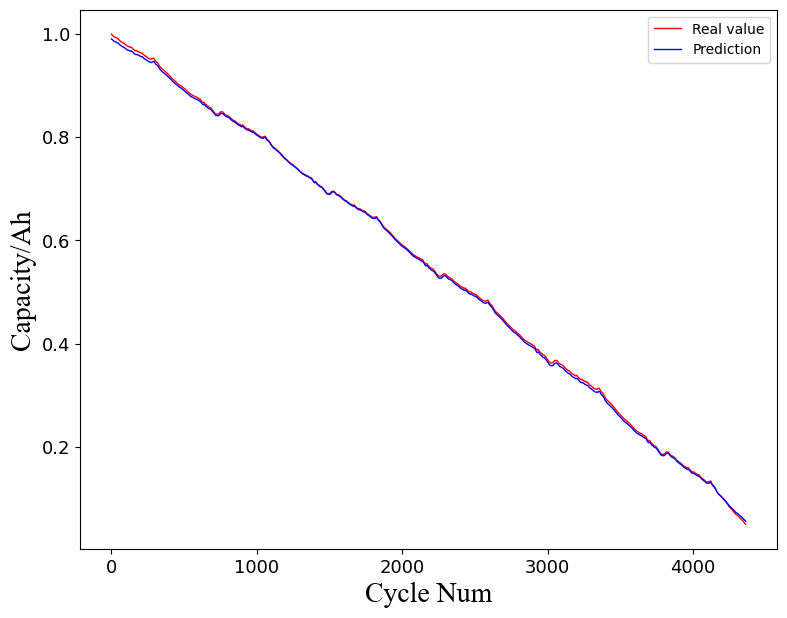

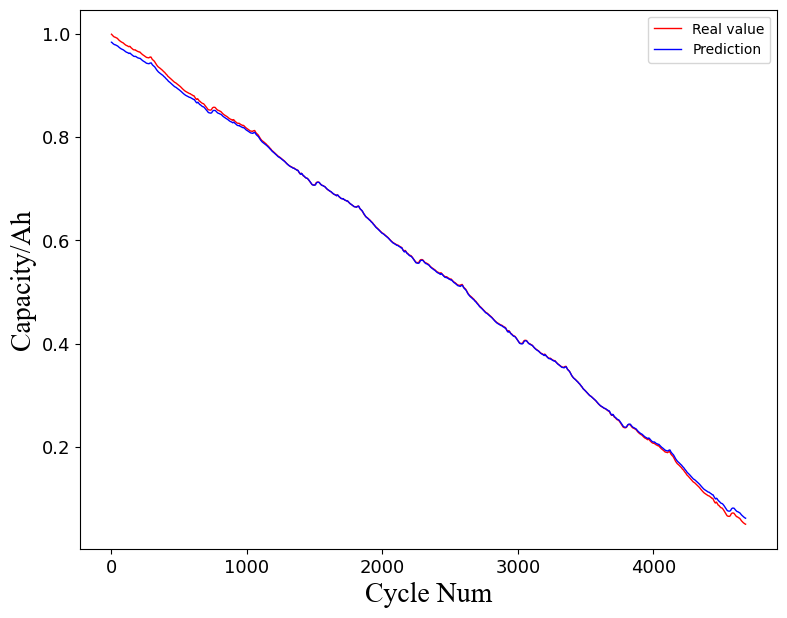

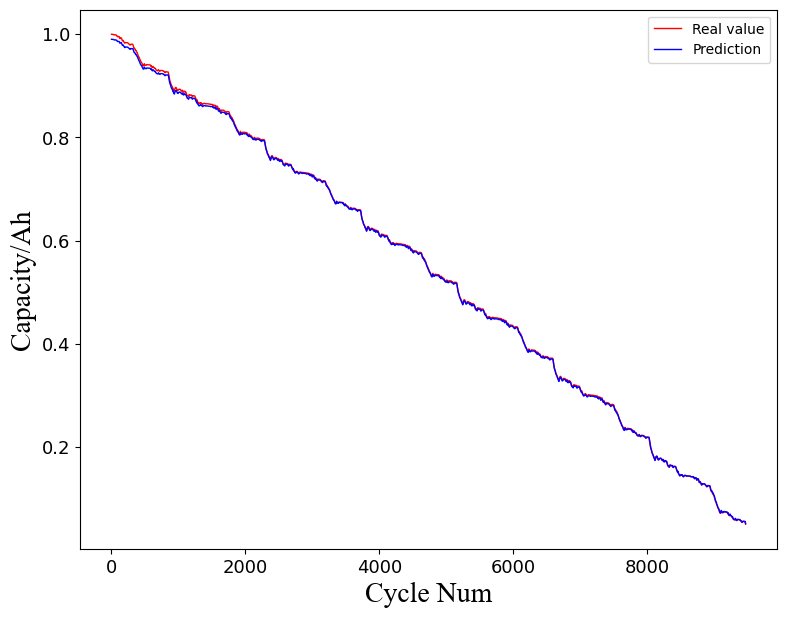

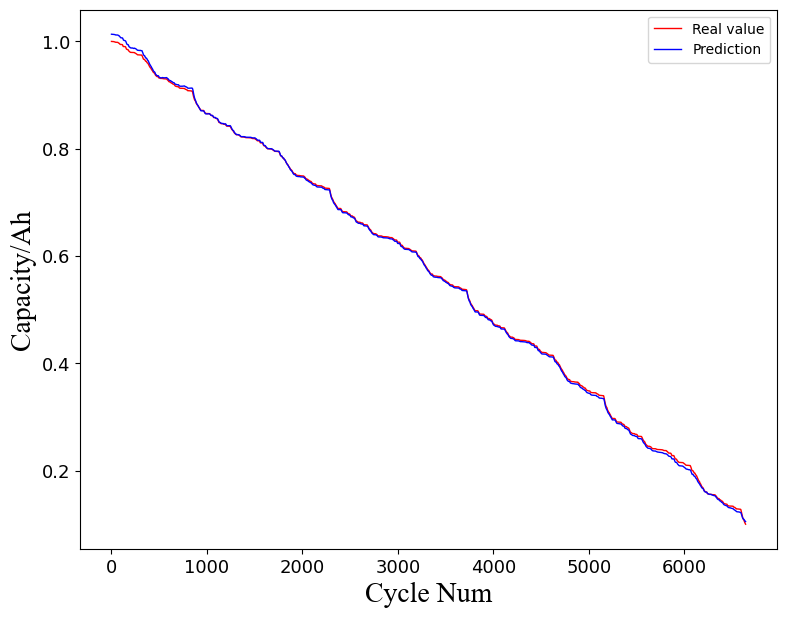

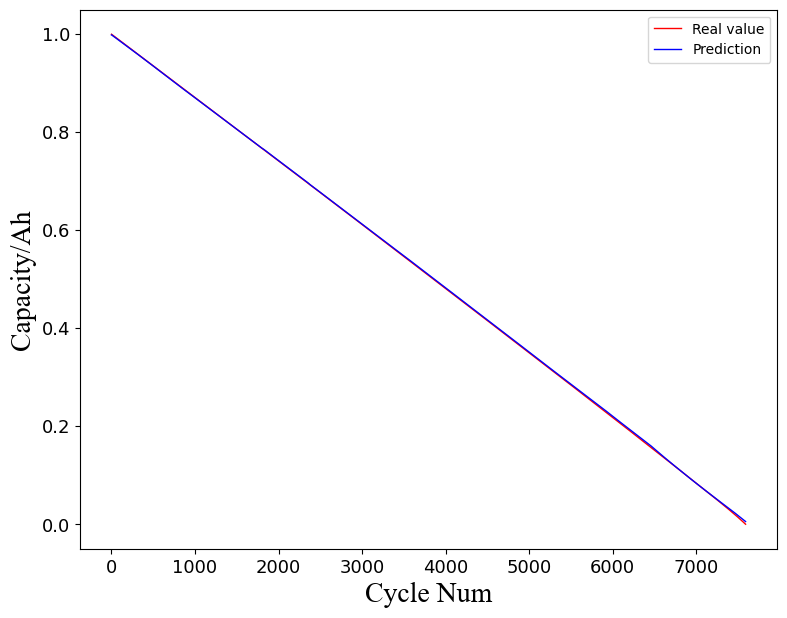

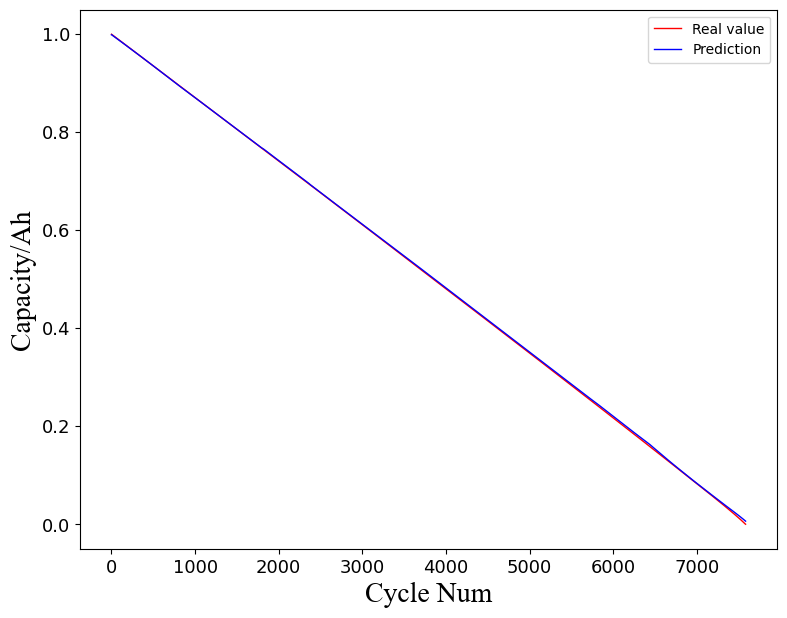

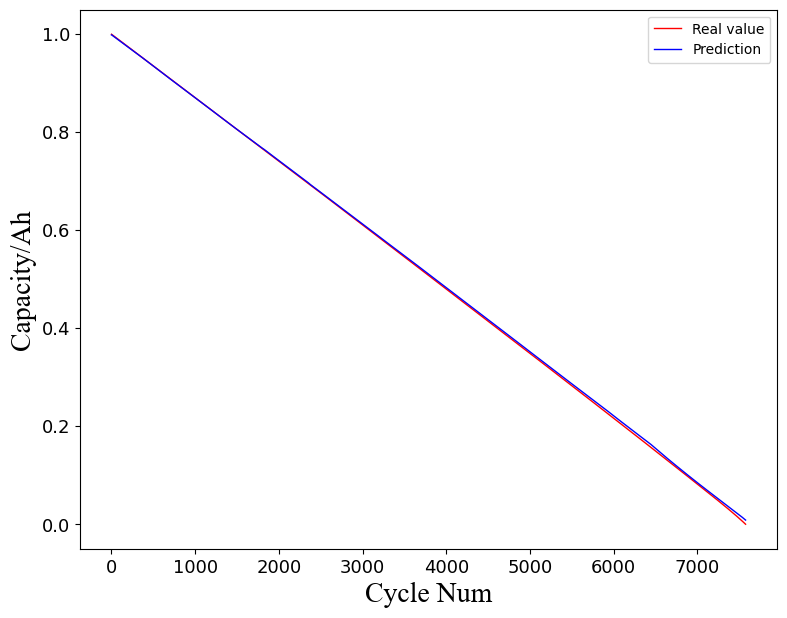

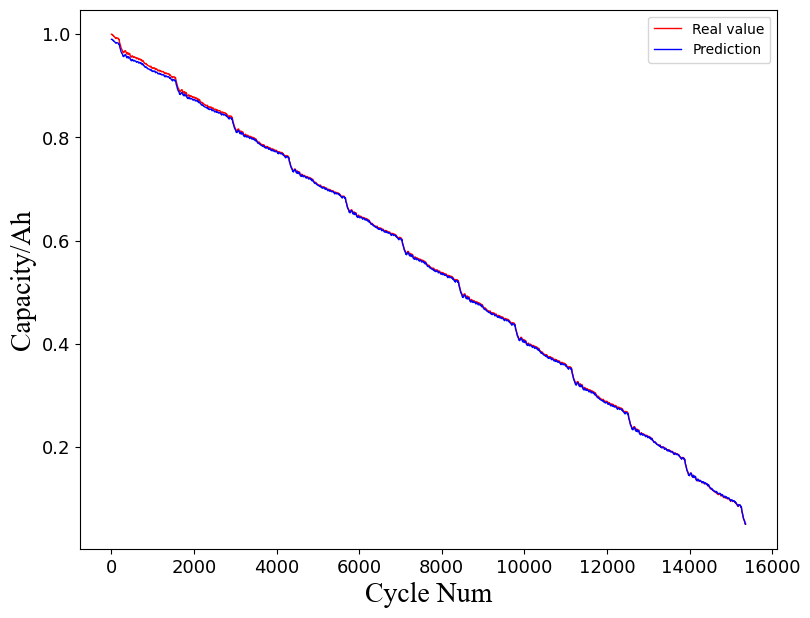

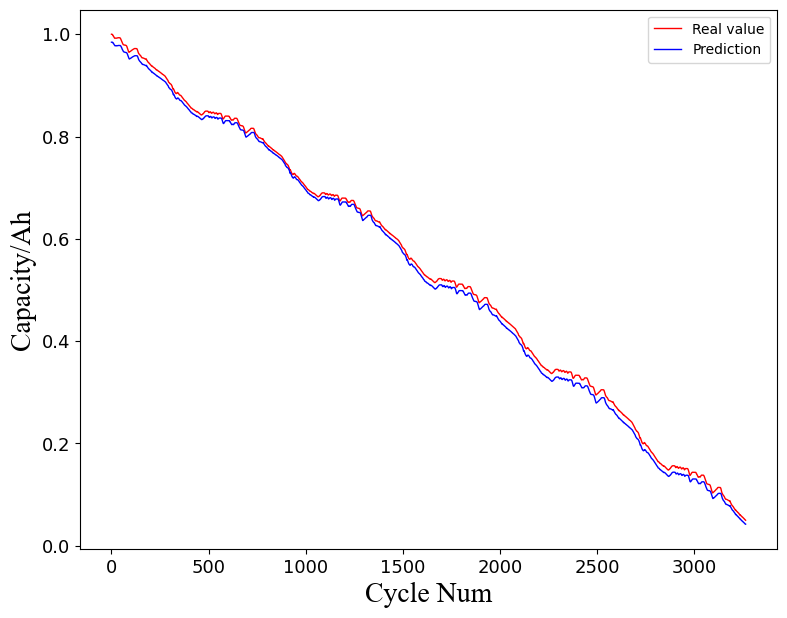

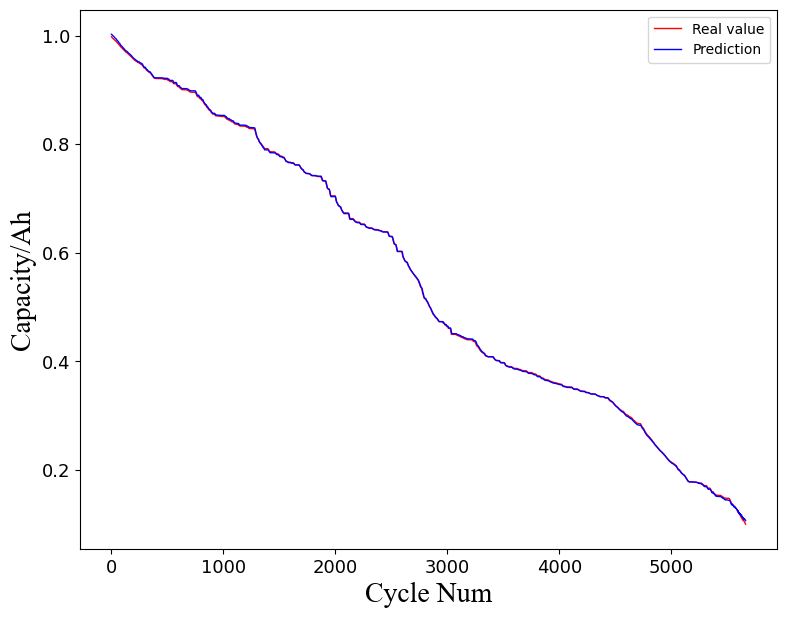

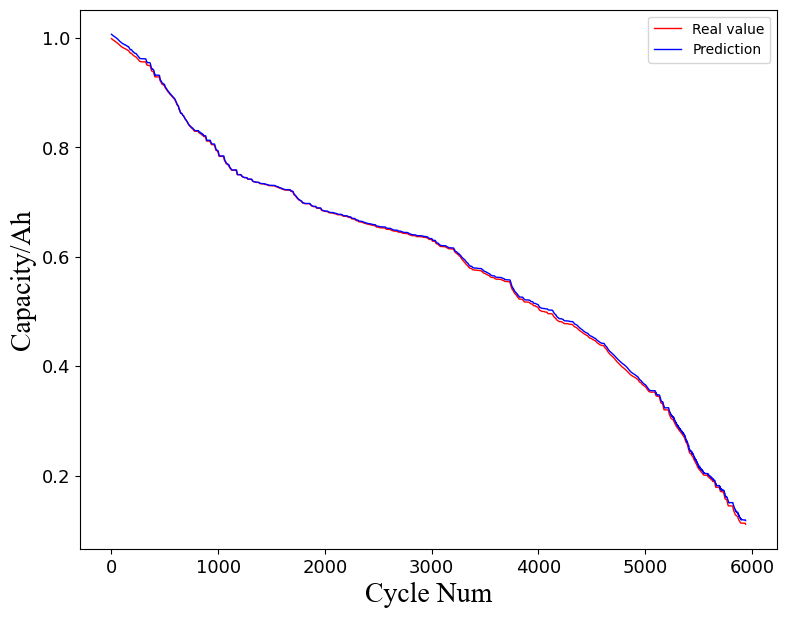

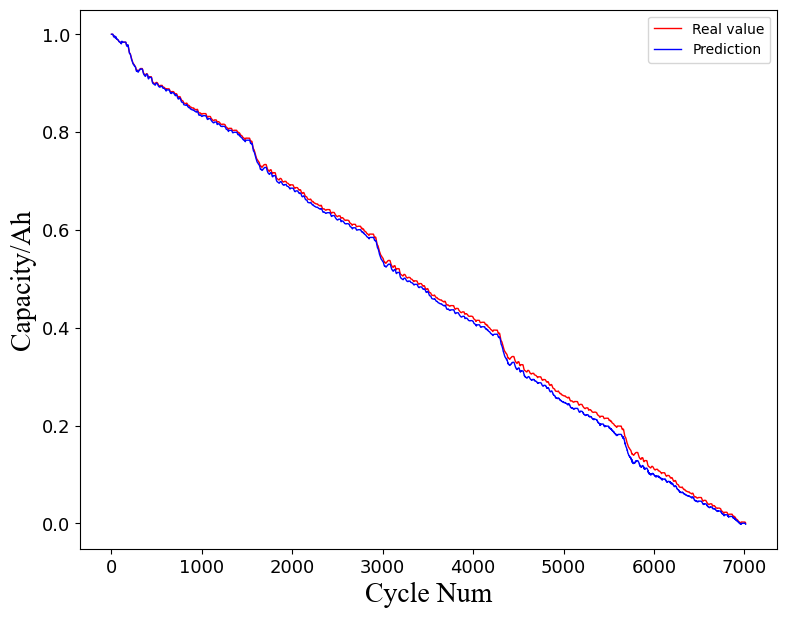

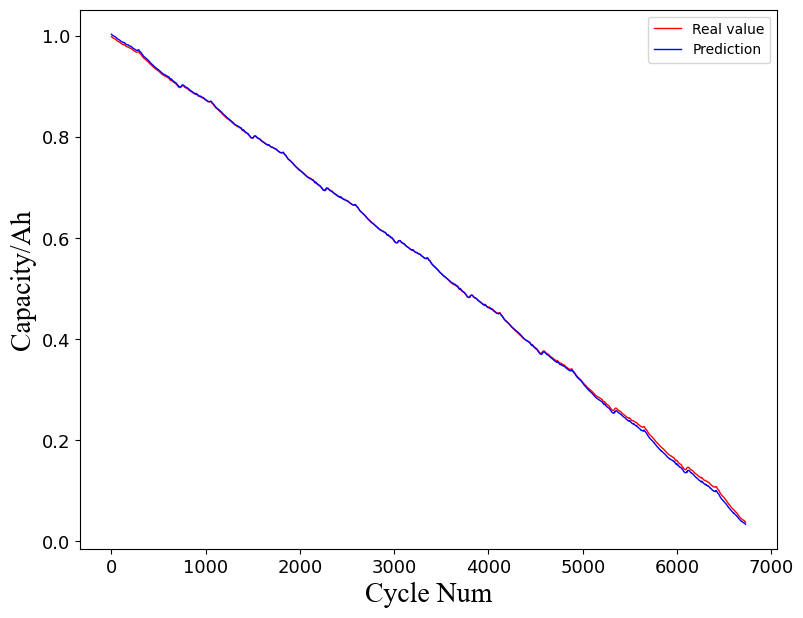

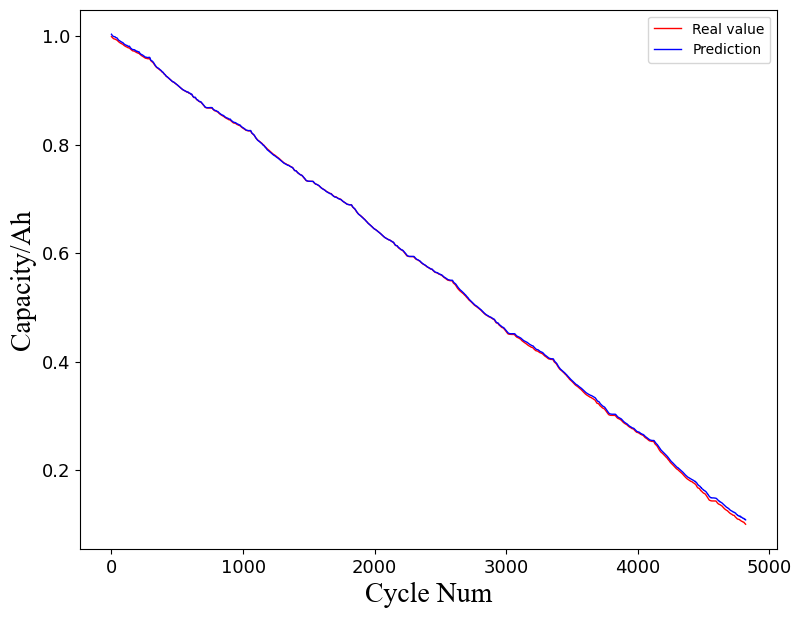

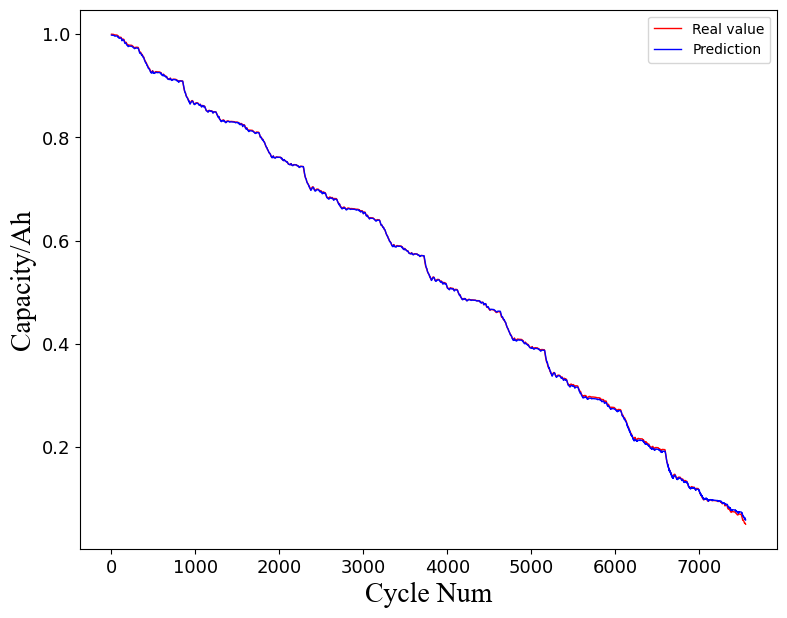

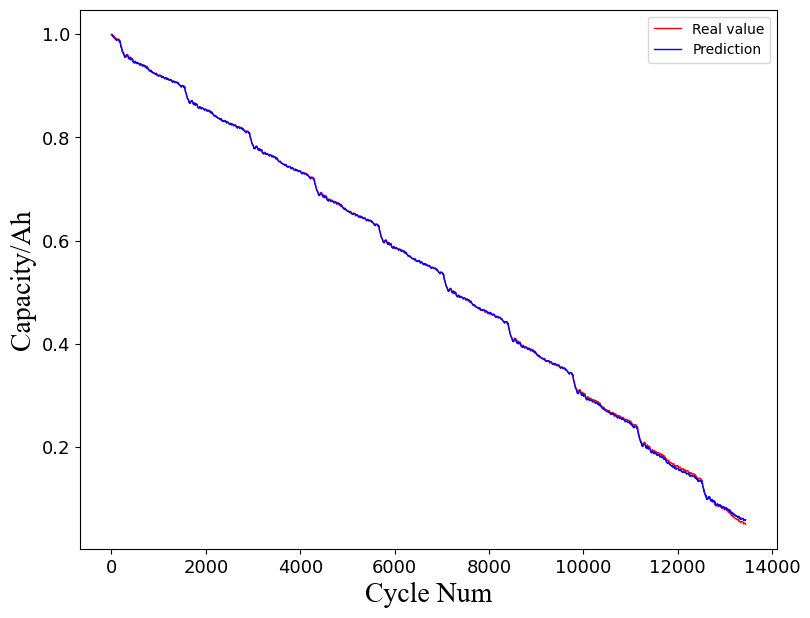

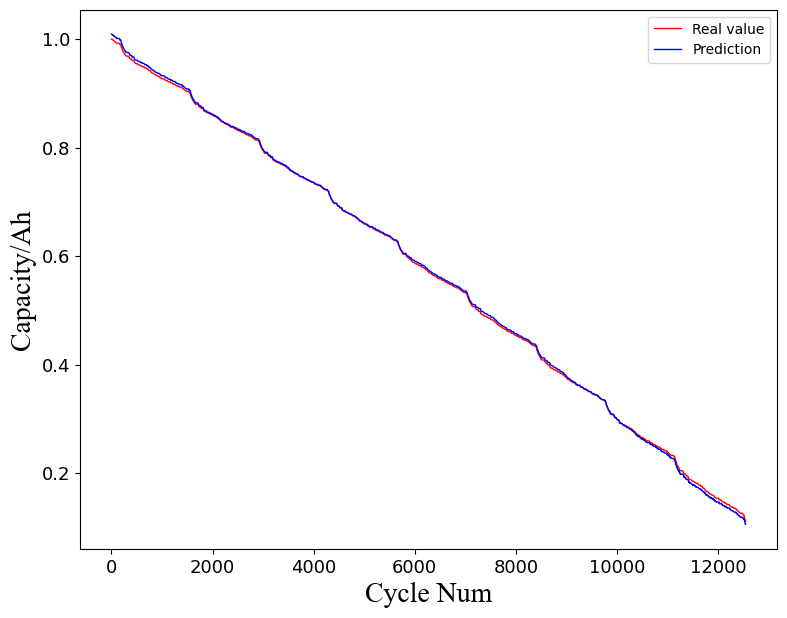

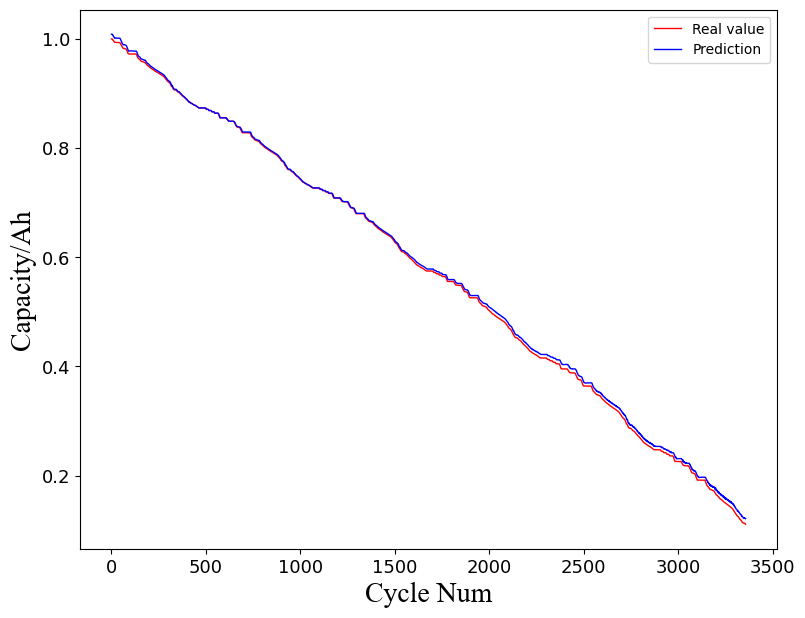

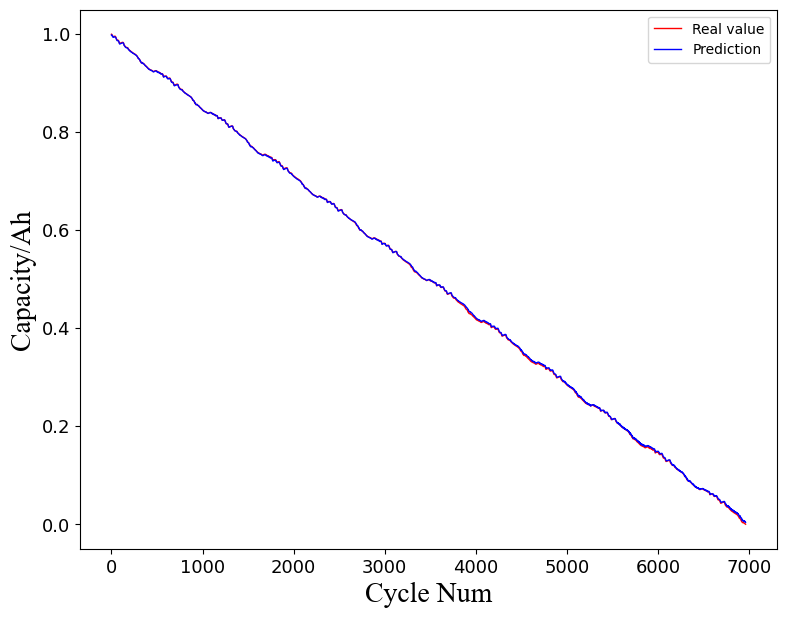

In [12]:
for fold in range(5):
    valid_folder = folder_names[fold]
    train_folders = [folder for folder in folder_names if folder != valid_folder]
    model = Net(4,128,1)
    model.to(device)
    maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False)
    opt = optim.Adam(maml.parameters(), meta_lr)
    loss = nn.MSELoss()
    model_filename = f"maml_modellstm_{str(fold)}.pth"
    optimizer_filename = f"optimizerlstm_{str(fold)}.pth"
    maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False) 
    maml.load_state_dict(torch.load(model_filename))
    opt = optim.Adam(maml.parameters(), meta_lr)
    opt.load_state_dict(torch.load(optimizer_filename))
    train_set = []
    valid_set = []
    for folder in train_folders:
        train_set += glob.glob(os.path.join(folder_path, folder, '*.mat'))
    valid_set += glob.glob(os.path.join(folder_path, valid_folder, '*.mat'))

    train_files = [os.path.splitext(os.path.basename(file))[0] for file in train_set]
    valid_files = [os.path.splitext(os.path.basename(file))[0] for file in valid_set]
    data_train = Mydataset(data_path, 'modif_gather', train_files)
    data_valid = Mydataset(data_path, 'modif_gather', valid_files)
    for j in range(len(valid_files)):
        learner = maml.clone()#克隆模型
        batch = data_valid[j]
        data2, labels = batch
        data2, labels = data2.to(device), labels.to(device)
        path = data_path + 'modif_gather' + '/' + valid_files[j] + '.mat'
        data2_orig = load_data(path)
        current_orig_1 = data2_orig['current_orig'].to(device)
        ah_orig_1 = data2_orig['ah_orig'].to(device)
        time_1 = data2_orig['time'].to(device)
        if 'Pan' in valid_files[j]:
            t1 = 'Pan'
            first_underscore_index = valid_files[j].index('_')
            second_underscore_index = valid_files[j].index('_', first_underscore_index + 1)
            t2 = valid_files[j][first_underscore_index :second_underscore_index+ 1]
            t3 = valid_files[j][0 :first_underscore_index]
            capacity_rated = 2.9
        elif 'LG' in valid_files[j]:
            t1 = 'LG'
            first_underscore_index = valid_files[j].index('_')
            second_underscore_index = valid_files[j].index('_', first_underscore_index + 1)
            t2 = valid_files[j][first_underscore_index :second_underscore_index+ 1]
            t3 = valid_files[j][0 :first_underscore_index]
            capacity_rated = 3
        elif 'A123' in valid_files[j]:
            t1 = 'A123'
            first_underscore_index = valid_files[j].index('_')
            second_underscore_index = valid_files[j].index('_', first_underscore_index + 1)
            t2 = valid_files[j][first_underscore_index :second_underscore_index+ 1]
            t3 = valid_files[j][0 :first_underscore_index]
            capacity_rated = 1.1
        elif 'Own' in valid_files[j]:
            t1 = 'Own'
            t2 = '_'
            t3 = '?'
            capacity_rated = 300
        else:
            print('wrong')
        predictions_no, predictions_bef_no, coefficient_no= learner(data2)
        predictions_no[1:] =  (predictions_no[1:] + predictions_bef_no[1:]+(((current_orig_1[:-1]/(coefficient_no[1:]*capacity_rated))*((time_1[1:]-time_1[:-1]) / 3600))).reshape(-1,1))/2      
        satisfying_data = []
        satisfying_labels = []
        satisfying_current_orig = []
        satisfying_ah_orig = []
        satisfying_time_1 = [] 
        satisfying_time_diff = []

        for i in range(len(train_files)):
            if t1 in train_files[i] and t2 in train_files[i] and t3 not in train_files[i]:
                batch_data, batch_labels = data_train[i]
                satisfying_data.append(batch_data[1:][1::3].to(device))
                satisfying_labels.append(batch_labels[1:][1::3].to(device))
                path = data_path + 'modif_gather' + '/' + train_files[i] + '.mat'
                data2_orig = load_data(path)
                
                satisfying_current_orig.append(data2_orig['current_orig'][:-1][1::3].to(device))
                satisfying_ah_orig.append(data2_orig['ah_orig'][1:][1::3].to(device))
                satisfying_time_1.append(data2_orig['time'][1:][1::3].to(device))
                time_diff = data2_orig['time'][1:] - data2_orig['time'][:-1]
                satisfying_time_diff.append(time_diff[1::3].to(device))

        combined_data = torch.cat(satisfying_data, dim=0)
        combined_labels = torch.cat(satisfying_labels, dim=0)
        combined_current_orig = torch.cat(satisfying_current_orig, dim=0)
        combined_ah_orig = torch.cat(satisfying_ah_orig, dim=0)
        combined_time_1 = torch.cat(satisfying_time_1, dim=0)
        combined_time_diff = torch.cat(satisfying_time_diff, dim=0)
        random_indices = random.sample(range(combined_data.size(0)), 1000)
        batch_data = combined_data[random_indices]
        batch_labels = combined_labels[random_indices]
        current_orig_1 = combined_current_orig[random_indices]
        ah_orig_1 = combined_ah_orig[random_indices]
        time_1 = combined_time_1[random_indices]
        time_diff = combined_time_diff[random_indices]
        with torch.backends.cudnn.flags(enabled=False):
            for step in range(adaptation_steps):
                output, out_bef, coefficient = learner(batch_data)
                PHY_loss = physical_inconsistency_batch(capacity_rated * coefficient, current_orig_1, time_diff, output, out_bef,'adaption')#
                output =  (output+ out_bef+(((current_orig_1/(coefficient*capacity_rated))*((time_diff) / 3600))).reshape(-1,1))/2
                empirical_error = loss(output, batch_labels)
                train_error = empirical_error+ PHY_loss
                learner.adapt(train_error)
        batch = data_valid[j]
        data2, labels = batch
        data2, labels = data2.to(device), labels.to(device)
        path = data_path + 'modif_gather' + '/' + valid_files[j] + '.mat'
        data2_orig = load_data(path)
        current_orig_1 = data2_orig['current_orig'].to(device)
        ah_orig_1 = data2_orig['ah_orig'].to(device)
        time_1 = data2_orig['time'].to(device)
        if 'Pan' in valid_files[j]:
                capacity_rated = 2.9
        elif 'LG' in valid_files[j]:
            capacity_rated = 3
        elif 'A123' in valid_files[j]:
            capacity_rated = 1.1
        elif 'Own' in valid_files[j]:
            capacity_rated = 300
        else:
            print('wrong')
        evaluation_data, evaluation_labels = data2, labels
        predictions, predictions_bef, coefficient= learner(evaluation_data)
        predictions[1:] =  (predictions[1:] + predictions_bef[1:]+(((current_orig_1[:-1]/(coefficient[1:]*capacity_rated))*((time_1[1:]-time_1[:-1]) / 3600))).reshape(-1,1))/2
        valid_error = loss(predictions, evaluation_labels)
        mae,mse,rmse = evaluation(y_test=evaluation_labels.cpu().detach().numpy(), y_predict=predictions.cpu().detach().numpy())
        print('MAE:{:<6.4f} |MSE:{:<6.4f} | RMSE:{:<6.4f}| type:{:<6s}'.format( mae,mse,rmse,valid_files[j]))
        fig=plt.figure(figsize=(9,7))
        font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 20}
        plt.plot(evaluation_labels.tolist(),'r-',label='Real value',linewidth=1.0) 
        plt.plot(predictions.tolist(),'b-',label='Prediction',linewidth=1.0) 
        plt.xlabel('Cycle Num',font)
        plt.ylabel('Capacity/Ah',font)
        plt.tick_params(labelsize=13) 
        plt.legend()
        df = pd.DataFrame({
            'Evaluation Labels': [val[0] for val in evaluation_labels.tolist()],
            'Predictions': [val[0] for val in predictions.tolist()],
            'Time': time_1.tolist(),
            'Predictions_no': [val[0] for val in predictions_no.tolist()]
        })    
        df.to_excel(os.path.join(save_folder, f'evaluation_results_{str(fold)}_{valid_files[j]}.xlsx'), index=False)
        
        del combined_data,combined_labels,combined_current_orig,combined_ah_orig,combined_time_1,combined_time_diff,
        del output, out_bef, current_orig_1, ah_orig_1, time_1, evaluation_data, evaluation_labels, data2, labels, predictions, predictions_bef, coefficient, fig
    del model, maml, opt